In [1]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

sys.path.insert(0, '..')

from core.model.model_disturbances import ModelDisturbances
from core.model.model_typical_disturbances import ModelTypicalDisturbances

## Input Disturbances

In [2]:
# Hourly precipitation, radiation, and temperature from CSV
hourly_input_disturbances = pd.read_csv(
    '../io/inputs/hourly_prcp_rad_temp_iowa.csv',
    header=None,
    names=[
        'Hourly Precipitation (mm)',
        'Hourly Radiation (W/m2)',
        'Temperature (C)'
    ]
)

In [3]:
# Set ModelDisturbances
input_disturbances = ModelDisturbances(
    precipitation = hourly_input_disturbances['Hourly Precipitation (mm)'].to_numpy(),
    radiation     = hourly_input_disturbances['Hourly Radiation (W/m2)'].to_numpy(),
    temperature   = hourly_input_disturbances['Temperature (C)'].to_numpy()
)

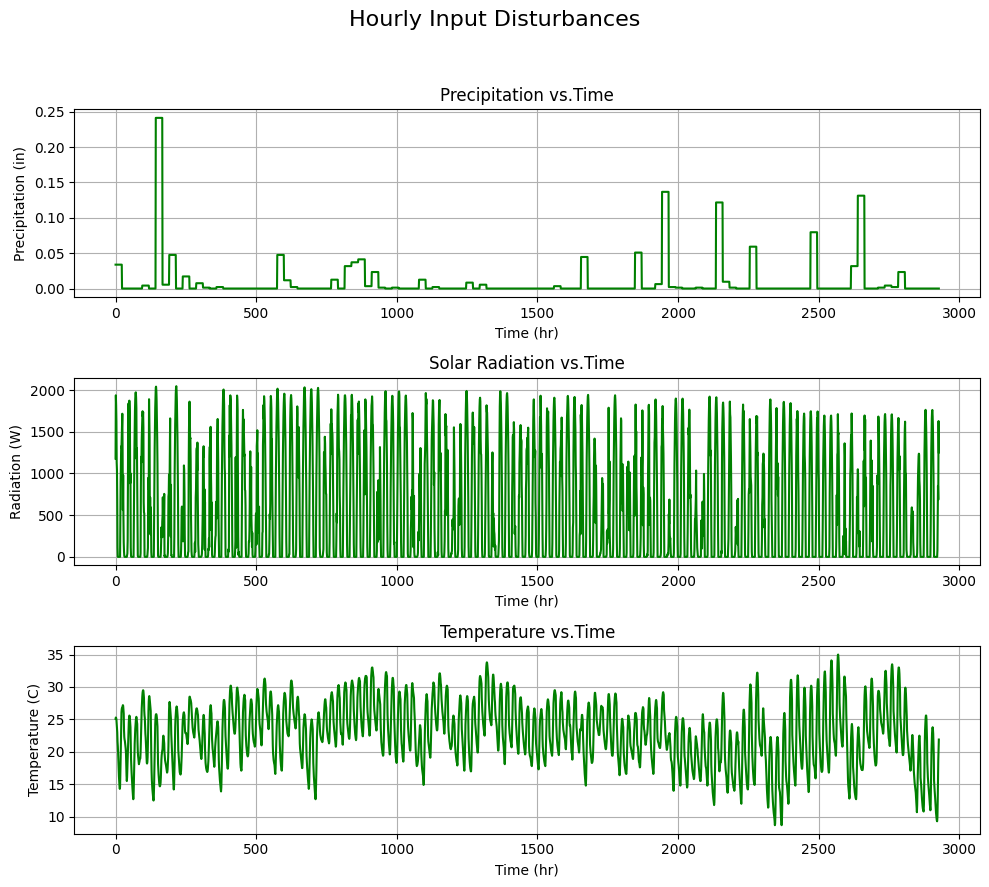

In [4]:
# Plot all of the input disturbances
fig, axs = plt.subplots(3, 1, figsize=(10, 9))
time = np.arange(len(input_disturbances.precipitation))

# Precipitation
axs[0].plot(time, input_disturbances.precipitation, color='green')
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Precipitation (in)')
axs[0].set_title(f'Precipitation vs.Time')
axs[0].grid(True)

# Solar Radiation
axs[1].plot(time, input_disturbances.radiation, color='green')
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Radiation (W)')
axs[1].set_title(f'Solar Radiation vs.Time')
axs[1].grid(True)

# Fruit Biomass
axs[2].plot(time, input_disturbances.temperature, color='green')
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Temperature (C)')
axs[2].set_title(f'Temperature vs.Time')
axs[2].grid(True)

fig.suptitle(f'Hourly Input Disturbances', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Control inputs

In [5]:
# Genetic algorithm style inputs
irrigation_frequency = 5*24    # once every X hours
irrigation_amount    = 0.01       # inches/acre per irrigation
fertilizer_frequency = 30 * 24 # once every X hours (~once a month)
fertilizer_amount    = 118     # pounds/acre per fertilization

In [6]:
# Apply irrigation and fertilizer based on the defined frequency and amount
simulation_hours = len(input_disturbances.precipitation)
hourly_irrigation = np.zeros(simulation_hours)
for t in range(0, simulation_hours, irrigation_frequency):
    hourly_irrigation[t] = irrigation_amount

hourly_fertilizer = np.zeros(simulation_hours)
for t in range(0, simulation_hours, fertilizer_frequency):
    hourly_fertilizer[t] = fertilizer_amount

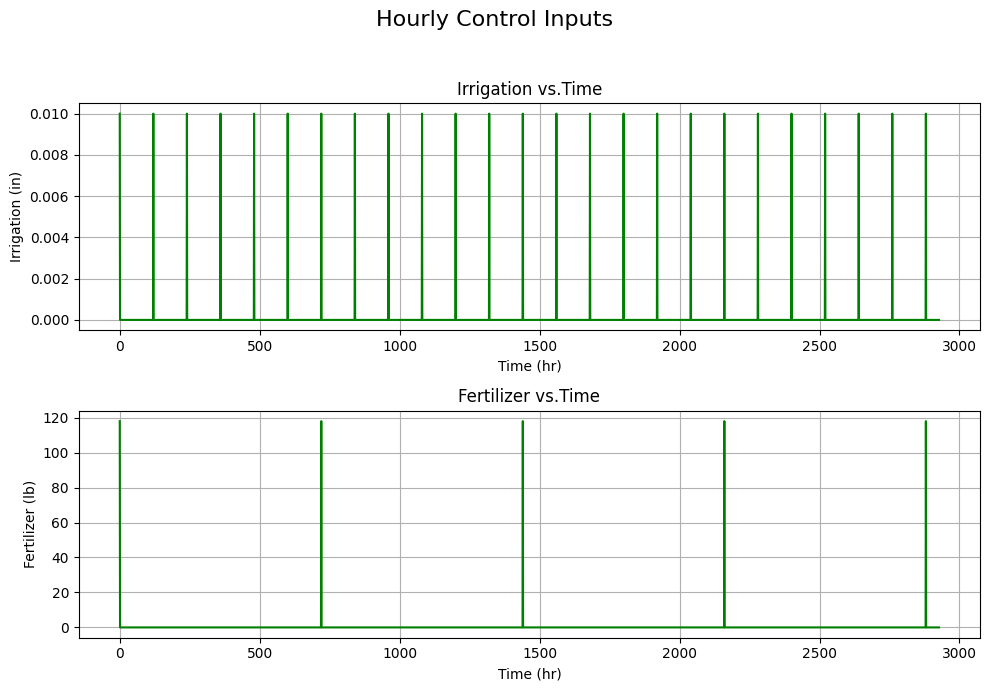

In [7]:
# Plot all of the control inputs
fig, axs = plt.subplots(2, 1, figsize=(10, 7))
time = np.arange(simulation_hours)

# Irrigation
axs[0].plot(time, hourly_irrigation, color='green')
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Irrigation (in)')
axs[0].set_title(f'Irrigation vs.Time')
axs[0].grid(True)

# Fertilizer
axs[1].plot(time, hourly_fertilizer, color='green')
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Fertilizer (lb)')
axs[1].set_title(f'Fertilizer vs.Time')
axs[1].grid(True)

fig.suptitle(f'Hourly Control Inputs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Cumulative Values

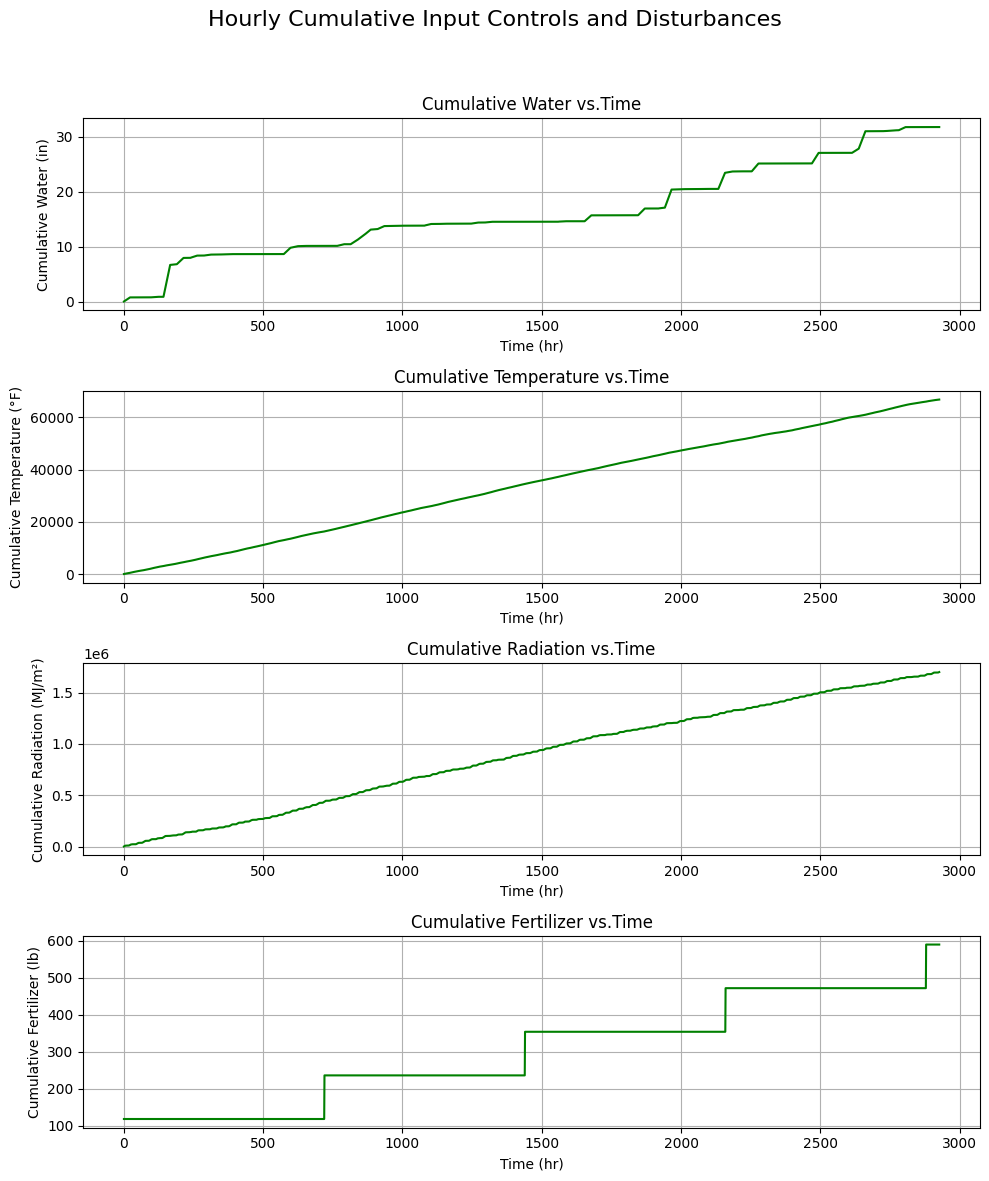

In [8]:
# Plot cumulative values
fig, axs = plt.subplots(4, 1, figsize=(10, 12))
time = np.arange(len(input_disturbances.precipitation))

# Calculate cumulative values
cumulative_precipitation = np.cumsum(input_disturbances.precipitation)
cumulative_temperature = np.cumsum(input_disturbances.temperature)
cumulative_radiation = np.cumsum(input_disturbances.radiation)
cumulative_irrigation = np.cumsum(hourly_irrigation)
cumulative_fertilizer = np.cumsum(hourly_fertilizer)

# Precipitation + Irrigation
axs[0].plot(time, cumulative_precipitation + cumulative_irrigation, color='green')
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Cumulative Water (in)')
axs[0].set_title(f'Cumulative Water vs.Time')
axs[0].grid(True)

# Temperature
axs[1].plot(time, cumulative_temperature, color='green')
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Cumulative Temperature (°F)')
axs[1].set_title(f'Cumulative Temperature vs.Time')
axs[1].grid(True)

# Radiation
axs[2].plot(time, cumulative_radiation, color='green')
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Cumulative Radiation (MJ/m²)')
axs[2].set_title(f'Cumulative Radiation vs.Time')
axs[2].grid(True)

# Fertilizer
axs[3].plot(time, cumulative_fertilizer, color='green')
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Cumulative Fertilizer (lb)')
axs[3].set_title(f'Cumulative Fertilizer vs.Time')
axs[3].grid(True)

fig.suptitle(f'Hourly Cumulative Input Controls and Disturbances', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Nutrient Factors

In [ ]:
# To calculate the "nutrient factors", we need to know the following
FC_opt = 355 # lbs/acre per season, cumulative fertilizer consumption
WC_opt = 28  # inches/acre per season, cumulative water consumption

#T_typ = np.mean(input_disturbances.temperature) # typical temperature over the season
#R_typ = np.mean(input_disturbances.radiation)   # typical radiation over the season
T_typ = 66821
R_typ = 1699527I

In [10]:
# # Nutrient factors are based on a sigma=1 Gaussian distribution
def get_nutrient_factor(x, mu):
    nu = 1/2 * (1 / (1 + np.exp(1/100*(x - mu))) + 1)
    return nu

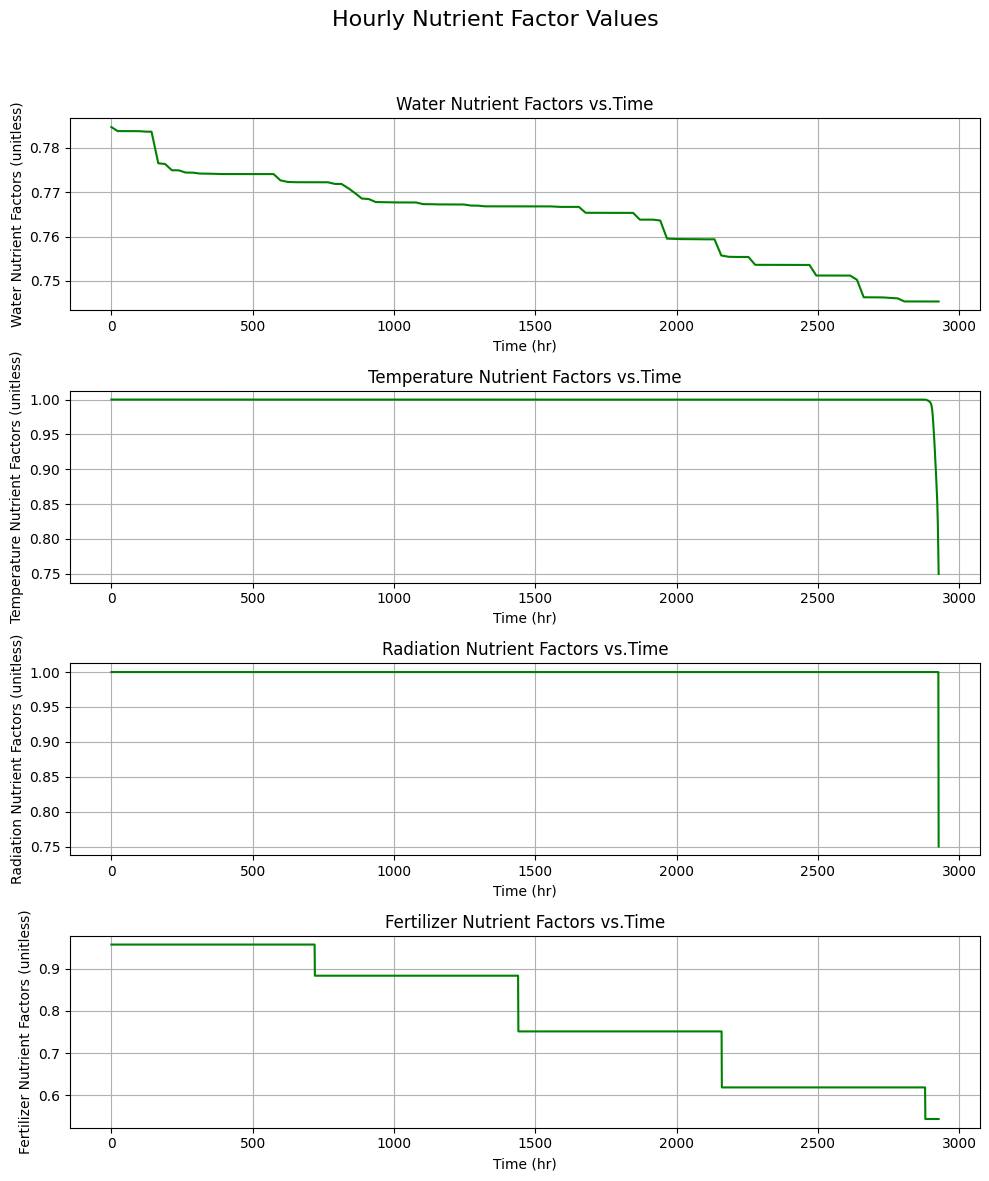

In [11]:
# Plot cumulative values
fig, axs = plt.subplots(4, 1, figsize=(10, 12))
time = np.arange(len(input_disturbances.precipitation))

# Calculate cumulative values
nutrient_factors_water = get_nutrient_factor(cumulative_precipitation + cumulative_irrigation, WC_opt)
nutrient_factors_temperature = get_nutrient_factor(cumulative_temperature, T_typ)
nutrient_factors_radiation = get_nutrient_factor(cumulative_radiation, R_typ)
nutrient_factors_fertilizer = get_nutrient_factor(cumulative_fertilizer, FC_opt)

# Precipitation + Irrigation
axs[0].plot(time, nutrient_factors_water, color='green')
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Water Nutrient Factors (unitless)')
axs[0].set_title(f'Water Nutrient Factors vs.Time')
axs[0].grid(True)

# Temperature
axs[1].plot(time, nutrient_factors_temperature, color='green')
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Temperature Nutrient Factors (unitless)')
axs[1].set_title(f'Temperature Nutrient Factors vs.Time')
axs[1].grid(True)

# Radiation
axs[2].plot(time, nutrient_factors_radiation, color='green')
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Radiation Nutrient Factors (unitless)')
axs[2].set_title(f'Radiation Nutrient Factors vs.Time')
axs[2].grid(True)

# Fertilizer
axs[3].plot(time, nutrient_factors_fertilizer, color='green')
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Fertilizer Nutrient Factors (unitless)')
axs[3].set_title(f'Fertilizer Nutrient Factors vs.Time')
axs[3].grid(True)

fig.suptitle(f'Hourly Nutrient Factor Values', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()